In [ ]:
from google.colab import auth, drive
import os
auth.authenticate_user()

# Link Google drive
drive.mount('/content/gdrive')
OUTPUT_DIR = '/content/gdrive/My Drive/Prescribing Cascade/data/'
os.chdir(OUTPUT_DIR)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install datasets transformers pandas==1.3.5 pickle5 pycaret

In [ ]:
from datasets import load_dataset
dataset = load_dataset("ade_corpus_v2", "Ade_corpus_v2_classification")

Downloading:   0%|          | 0.00/3.02k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/307k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/18.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/868k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

Dataset ade_corpus_v2 downloaded and prepared to /root/.cache/huggingface/datasets/ade_corpus_v2/Ade_corpus_v2_classification/1.0.0/940d61334dbfac6b01ac5d00286a2122608b8dc79706ee7e9206a1edb172c559. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset['train'].set_format("pandas")

In [ ]:
df = dataset['train'][:]

In [ ]:
df['label'].value_counts()

0    16695
1     6821
Name: label, dtype: int64

In [ ]:
import pandas as pd
used_cols = ['text','label']
n2c2_train = pd.read_csv('./ade_related_unrelated.csv')[used_cols]
n2c2_test = pd.read_csv('./ade_related_unrelated_test.csv')[used_cols]

In [ ]:
n2c2_train.shape

(42640, 2)

In [ ]:
n2c2_train['label'].value_counts()

0    41681
1      959
Name: label, dtype: int64

In [ ]:
n2c2_test.shape

(28633, 2)

In [ ]:
n2c2_test['label'].value_counts()

0    28008
1      625
Name: label, dtype: int64

In [ ]:
df.shape

(23516, 2)

In [ ]:
df['label'].value_counts()

0    16695
1     6821
Name: label, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
adev2_train, adev2_test = train_test_split(df,test_size=0.2)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec_ade = TfidfVectorizer()
ade_v2_texts_train = tfidf_vec_ade.fit_transform(adev2_train['text'].values) 
ade_v2_texts_test = tfidf_vec_ade.transform(adev2_test['text'].values)
ade_v2_train_labels = adev2_train['label'].values
ade_v2_test_labels = adev2_test['label'].values

In [ ]:
from sklearn.metrics import classification_report
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_jobs=-1)
brf.fit(ade_v2_texts_train,ade_v2_train_labels)
y_pred = brf.predict(ade_v2_texts_test)

print(classification_report(ade_v2_test_labels,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90      3383
           1       0.70      0.85      0.77      1321

    accuracy                           0.86      4704
   macro avg       0.82      0.86      0.83      4704
weighted avg       0.87      0.86      0.86      4704



In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
stk = StratifiedKFold()
for train_inds, test_inds in stk.split(n2c2_texts_train,n2c2_train_labels):
  X_train = n2c2_texts_train[train_inds]
  Y_train = n2c2_train_labels[train_inds]
  X_test = n2c2_texts_train[test_inds]
  Y_test = n2c2_train_labels[test_inds]

  model = BalancedRandomForestClassifier()
  model.fit(X_train,Y_train)
  y_pred = model.predict(X_test)
  print(classification_report(Y_test,y_pred))
# scores = cross_val_score(BalancedRandomForestClassifier(),n2c2_texts_train,n2c2_train_labels,scoring="f1")

              precision    recall  f1-score   support

           0       1.00      0.87      0.93      8336
           1       0.13      0.86      0.22       192

    accuracy                           0.87      8528
   macro avg       0.56      0.87      0.58      8528
weighted avg       0.98      0.87      0.91      8528

              precision    recall  f1-score   support

           0       1.00      0.86      0.93      8336
           1       0.13      0.90      0.23       192

    accuracy                           0.87      8528
   macro avg       0.57      0.88      0.58      8528
weighted avg       0.98      0.87      0.91      8528

              precision    recall  f1-score   support

           0       1.00      0.86      0.93      8336
           1       0.13      0.88      0.23       192

    accuracy                           0.87      8528
   macro avg       0.56      0.87      0.58      8528
weighted avg       0.98      0.87      0.91      8528

              preci

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score
def eval_fold(data,labels):
  stk = StratifiedKFold(shuffle=True)
  f1s = []
  for train_inds, test_inds in stk.split(data,labels):
    X_train = data[train_inds]
    Y_train = labels[train_inds]
    X_test = data[test_inds]
    Y_test = labels[test_inds]

    model = BalancedRandomForestClassifier()
    model.fit(X_train,Y_train)
    y_pred = model.predict(X_test)
    print(classification_report(Y_test,y_pred))
    f1s.append(f1_score(Y_test,y_pred))
  return f1s

In [ ]:
eval_fold(ade_v2_texts_train,ade_v2_train_labels)

              precision    recall  f1-score   support

           0       0.93      0.87      0.90      2663
           1       0.72      0.84      0.77      1100

    accuracy                           0.86      3763
   macro avg       0.82      0.85      0.83      3763
weighted avg       0.87      0.86      0.86      3763

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      2663
           1       0.71      0.82      0.76      1100

    accuracy                           0.85      3763
   macro avg       0.82      0.84      0.83      3763
weighted avg       0.86      0.85      0.85      3763

              precision    recall  f1-score   support

           0       0.93      0.85      0.89      2662
           1       0.70      0.84      0.76      1100

    accuracy                           0.85      3762
   macro avg       0.81      0.84      0.83      3762
weighted avg       0.86      0.85      0.85      3762

              preci

[0.7732435843500209,
 0.7613012251795522,
 0.7626137303556658,
 0.783479349186483,
 0.757753562447611]

In [ ]:
f1_scores = eval_fold(tfidf_train,train_labels)

              precision    recall  f1-score   support

           0       0.99      0.85      0.91     11676
           1       0.44      0.91      0.59      1556

    accuracy                           0.85     13232
   macro avg       0.71      0.88      0.75     13232
weighted avg       0.92      0.85      0.87     13232

              precision    recall  f1-score   support

           0       0.99      0.85      0.91     11675
           1       0.44      0.91      0.60      1556

    accuracy                           0.85     13231
   macro avg       0.71      0.88      0.75     13231
weighted avg       0.92      0.85      0.87     13231

              precision    recall  f1-score   support

           0       0.99      0.85      0.91     11675
           1       0.45      0.93      0.61      1556

    accuracy                           0.86     13231
   macro avg       0.72      0.89      0.76     13231
weighted avg       0.93      0.86      0.88     13231

              preci

In [ ]:
f1_scores

[0.5941845764854614,
 0.5970211873295573,
 0.6082929909492738,
 0.5991226237727177,
 0.5985990235618766]

In [ ]:
scores

array([0.22192152, 0.2419128 , 0.22739726, 0.22012154, 0.23167155])

In [ ]:
tfidf_vec_n2c2 = TfidfVectorizer()
n2c2_texts_train = tfidf_vec_n2c2.fit_transform(n2c2_train['text'].values) 
n2c2_texts_test = tfidf_vec_n2c2.transform(n2c2_test['text'].values)
n2c2_train_labels = n2c2_train['label'].values
n2c2_test_labels = n2c2_test['label'].values

In [ ]:
brf = BalancedRandomForestClassifier(n_jobs=-1)
brf.fit(n2c2_texts_train,n2c2_train_labels)
y_pred_n2c2 = brf.predict(n2c2_texts_test)

print(classification_report(n2c2_test_labels,y_pred_n2c2))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92     28008
           1       0.12      0.87      0.21       625

    accuracy                           0.86     28633
   macro avg       0.56      0.86      0.57     28633
weighted avg       0.98      0.86      0.91     28633



# Here, the f1 score is of 21%. This is for training only on n2c2, and evaluating solely on n2c2's test set

In [ ]:
all_train = pd.concat([df,n2c2_train])

In [ ]:
train_texts = all_train['text'].values
train_labels = all_train['label'].values

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

In [ ]:
from nltk.stem.porter import PorterStemmer
from string import punctuation
import re

porter = PorterStemmer()

unused_patt = re.compile(rf"\[\*\*[^\*]+\*\*]")
punc_patt = re.compile(rf'[{punctuation}]')

def clean_sentence(text):
  no_unused = unused_patt.sub(' ',text.lower())
  no_punc_text = punc_patt.sub('',no_unused)
  toks = [porter.stem(tok) for tok in text.split()]
  return ' '.join(toks)

def clean_sentences(texts):
  return list(map(clean_sentence,texts))

In [ ]:
clean_train_texts = clean_sentences(train_texts)
test_texts = n2c2_test['text'].values
test_labels = n2c2_test['label'].values
clean_test_texts = clean_sentences(test_texts)

In [ ]:
def make_df(features,labels):
  dense = features.toarray()
  df = pd.DataFrame(dense,columns=[f'feature-{i}' for i in range(dense.shape[1])])
  df['label'] = labels.flatten()
  return df

In [ ]:
tfidf_vec = TfidfVectorizer()

In [ ]:
tfidf_train = tfidf_vec.fit_transform(clean_train_texts)

In [ ]:
tfidf_test = tfidf_vec.transform(clean_test_texts)

In [ ]:
tfidf_train.shape

(66156, 27739)

In [ ]:
from xgboost import XGBClassifier

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def eval_model(model,X_train=tfidf_train,Y_train=train_labels,X_test=tfidf_test,Y_test=test_labels):
  model.fit(X_train,Y_train)
  y_pred = model.predict(X_test)
  print(classification_report(Y_test,y_pred))
  print(confusion_matrix(Y_test,y_pred))

In [ ]:
import imblearn
print(imblearn.__version__)

0.7.0


In [ ]:
clf = BalancedRandomForestClassifier(n_estimators=5000,n_jobs=-1,class_weight={0:20,1:1})
eval_model(clf)

KeyboardInterrupt: ignored

In [ ]:
import sklearn
sklearn.__version__

'0.23.2'

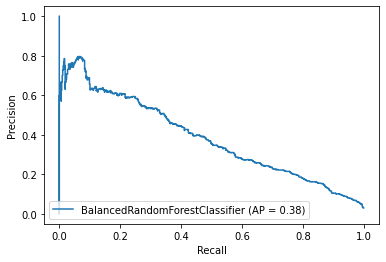

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve
y_pred = best_clf.predict_proba(tfidf_test)[:,1]
precision, recall, thresholds = precision_recall_curve(test_labels,y_pred)
# PrecisionRecallDisplay.from_predictions(y_test,test_labels)
plot_precision_recall_curve(best_clf,tfidf_test,test_labels)
# plt.title("Precision/Recall Curve of Balanced RandomForest Classifier")
plt.savefig('precision_recall_1k_brf.png')
plt.show()

# This is a plot of precision vs recall. Preferabbly, we want a high precision with a decent recall. The peak in the curve (recall=0.12, precision=0.82) looks promising.

In [ ]:
precision

In [ ]:
save_pickle(f"balanced_rf_1k_estimators_diff.pickle",clf)

In [ ]:
def load_pickle(filepath):
  with open(filepath,"rb") as f:
    return pickle.load(f)

In [ ]:
best_clf = load_pickle('balanced_rf_1k_estimators.pickle')

In [ ]:
import pickle5 as pickle
def save_pickle(filename,obj):
  with open(filename,"wb") as f:
    pickle.dump(obj,f)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
eval_model(RandomForestClassifier(class_weight="balanced"))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     28008
           1       0.50      0.02      0.04       625

    accuracy                           0.98     28633
   macro avg       0.74      0.51      0.51     28633
weighted avg       0.97      0.98      0.97     28633



In [ ]:
eval_model(BalancedRandomForestClassifier(n_estimators=1000))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     28008
           1       0.33      0.47      0.39       625

    accuracy                           0.97     28633
   macro avg       0.66      0.72      0.68     28633
weighted avg       0.97      0.97      0.97     28633



In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier, RUSBoostClassifier, EasyEnsembleClassifier
models = [
          BalancedRandomForestClassifier(),
          BalancedBaggingClassifier(),
          RUSBoostClassifier(),
          EasyEnsembleClassifier()
]
model_names = [
               'balanced rf',
               'balanced bag',
               'rus boost',
               'easy ensemble'
]

for model_name, model in zip(model_names,models):
  print(f"FITTING FOR MODEL {model_name}")
  eval_model(model)

FITTING FOR MODEL balanced rf
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     28008
           1       0.33      0.47      0.38       625

    accuracy                           0.97     28633
   macro avg       0.66      0.72      0.68     28633
weighted avg       0.97      0.97      0.97     28633

FITTING FOR MODEL balanced bag
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     28008
           1       0.20      0.42      0.27       625

    accuracy                           0.95     28633
   macro avg       0.59      0.69      0.62     28633
weighted avg       0.97      0.95      0.96     28633

FITTING FOR MODEL rus boost
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     28008
           1       0.18      0.49      0.26       625

    accuracy                           0.94     28633
   macro avg       0.58      0.72      

# Here, we can see the model "Balanced RF" performed with an f1 score of 38%. It was trained on n2c2's training set and ADE v2 corpus training set.

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 8.5 MB/s 
     |████████████████████████████████| 80 kB 10.7 MB/s 
     |████████████████████████████████| 149 kB 86.2 MB/s 
     |████████████████████████████████| 49 kB 6.6 MB/s 
     |████████████████████████████████| 112 kB 42.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=13b4aac51d5ba01e8c906f92acc21cc1c74a2bb43a196343a73f997b44609ed5
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
tfidf_train_bal.shape

(65908, 5000)

(array([58128.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  7780.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

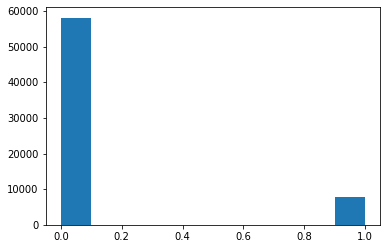

In [ ]:
import matplotlib.pyplot as plt
plt.hist(train_labels_bal)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
eval_model(RandomForestClassifier(class_weight='balanced'))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     28008
           1       0.50      0.02      0.03       625

    accuracy                           0.98     28633
   macro avg       0.74      0.51      0.51     28633
weighted avg       0.97      0.98      0.97     28633



In [ ]:
import optuna
from sklearn.metrics import f1_score
def objective(trial):
  n_estimators = trial.suggest_int('n_estimators',100,10000)
  criterion = trial.suggest_categorical('criterion',['gini','entropy'])
  # max_depth = trial.suggest_int('max_depth',)
  ccp_alpha = trial.suggest_float('ccp_alpha',0.001,100)
  max_features = trial.suggest_categorical('max_features',['sqrt','log2'])
  class_weight = trial.suggest_categorical('class_weight',['balanced','balanced_subsample'])
  model = BalancedRandomForestClassifier(n_estimators=n_estimators,criterion=criterion,max_depth=None,n_jobs=-1,ccp_alpha=ccp_alpha)
  model.fit(tfidf_train,train_labels)
  preds = model.predict(tfidf_test)
  return f1_score(test_labels,preds)

In [ ]:
study = optuna.create_study()
study.optimize(objective,n_trials=100)

[I 2022-01-27 04:04:44,413] A new study created in memory with name: no-name-4541d15e-41a1-40c7-b7c1-8d47f76d58c3
[I 2022-01-27 04:15:06,826] Trial 0 finished with value: 0.04272335771412947 and parameters: {'n_estimators': 5324, 'criterion': 'entropy', 'ccp_alpha': 24.01623421527492, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.04272335771412947.


KeyboardInterrupt: ignored

In [ ]:
print(study.best_)

In [ ]:
eval_model(XGBClassifier(scale_pos_weight=9))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     28008
           1       0.19      0.49      0.27       625

    accuracy                           0.94     28633
   macro avg       0.59      0.72      0.62     28633
weighted avg       0.97      0.94      0.95     28633



In [ ]:
eval_model(XGBClassifier(),X_train=tfidf_train_bal.toarray(),Y_train=train_labels_bal)

In [ ]:
from imblearn.combine import SMOTETomek
algo = SMOTETomek()
tfidf_train_bal, train_labels_bal  = algo.fit_resample(tfidf_train, train_labels)

In [ ]:
tfidf_train.shape

(66156, 5000)

In [ ]:
tfidf_train_bal.shape

(116752, 5000)

In [ ]:
tfidf_train_bal

<116752x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2073656 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
eval_model(MultinomialNB(alpha=1))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     28008
           1       0.50      0.00      0.01       625

    accuracy                           0.98     28633
   macro avg       0.74      0.50      0.50     28633
weighted avg       0.97      0.98      0.97     28633

